# Bed Analysis by Z-Probe

This notebook calculate the gcode required to probe the Trium delta printer. In principle, the code can be adapted to any delta printer by appropriate changes to the contants.

The sample points are calculated on a regular grid according to the user-specified sampling density, plus a series of additional points near the towers and in the centre of the bed.  The points are carefully selected to present three points on lines partway to the tower. These three points correspond to the points on a smaller four-point test.  The idea is to use the detailed sampling less often and then use the four-point sample test for regular levelling.

## Repetier Logfile

It is somewhat of a mission to do a long multi-sample mesh probe with Repetier. For a few samples the log display on the screen is sufficiently large to capture all data.  However, for the 84-sample probe file created in here, the screen log area refreshes and loses some of the information. To capture the full log, you must use the Repetier log file on disk.  The procedure is as follows:

- Switch on the disk log file capture (by default is is off) using the Config/Preferences menu setting.
- Close Repetier to make the change effective.
- Execute the bed probing with the 84 sample file.
- Close Repetier again to force the completion of the log file writing to disk.
- Open the log file from disk in the directory `%USER%\AppData\Local\RepetierHost` ( you can change the location in the preferences setting.
- Cut the portion containing the information.


## Input data

The settings shown below were carefully tuned to achieve the following objectives:
- Keep the PWM fans clear of the Y and Z towers when probing.
- Keep the probe on the bed.
- Include the centre as a valid sample point.
- Include three sample points on a line between the centre and a tower, near a tower, such that the point can be compared with a simpler sampling procedure used for bed levelling.
- Give a reasonable sampling density at regular intervals.
- Do regular G28 homing commands. 



In [2]:
# to prepare and load constants

import numpy as np
from scipy.interpolate import interp2d
import pyradi.ryplot as ryplot
import pandas as pd
%matplotlib inline

np.set_printoptions(linewidth=120)
pd.set_option('display.width', 120)

bedRadius = 110. 
towerRadius = 180. # centre to belts
towerClearance = 70. # distance nozzle to outmost fan part
probeRadius = 104. # don't probe near edges
samplintx = 18.125 # sample interval in mm
samplinty = 22 # sample interval in mm
maxsize = 2.5 *  bedRadius  # number of points spread over this distance
xoffset = -33.5 # probe offset from nozzle
yoffset = -5. # probe offset from nozzle
numg28 = 2 # number of samples between g28 
numg30=5 # number of probes per one position

In [3]:
# to create the grid
x = np.arange(0,maxsize,samplintx)
x = np.sort(np.append(x,-x[1:]))
y = np.arange(0,maxsize,samplinty)
y = np.sort(np.append(y,-y[1:]))

# xx,yy are the required probe positions
xx,yy = np.meshgrid(x,y)
radius = np.sqrt(xx*xx+yy*yy)
# xn, yn are the nozzle positions corresponding to the above probe positions
xn = xx - xoffset
yn = yy - yoffset

# p = ryplot.Plotter(1,1,1,figsize=(8,7));
# p.meshContour(1,xx,yy,radius,contLabel=True,cbarshow=True);
# print(np.unique(xx))
# print(np.unique(yy))



The code below starts with a full and large grid of sampling points and then eliminates the illegal sample points.  Towards the Y tower some sampling points have to be dropped to prevent the fan from moving in into the Y-tower belt.

The gcode file created with this data set creates 84 samples over most of the bed.

In [14]:
# to eliminate the 'illegal' points
# Y tower, cutout around the tower by a sloping line, X limit and Y limit
coffset =  - (towerRadius-towerClearance) / np.tan(np.pi * 30. / 180.) 
slope = 2.
maskYs = yy >  slope*xx+coffset
maskYx = xx<50.
maskYy = yy>-30.
maskY =  np.logical_or( maskYs, np.logical_or(maskYy,maskYx))
# Z tower
maskZ = yy  <  towerRadius-towerClearance
# probe area within the head
maskB = radius <= probeRadius

# start with all possible points, then remove points below
valid = np.ones((xx.shape))
valid =  np.logical_and(valid,maskY)
valid =  np.logical_and(valid, maskZ) 
valid = np.logical_and(valid, maskB)

# create circles for plotting below
rang = np.linspace(0,2*np.pi,360)
xb = bedRadius * np.sin(rang)
yb = bedRadius * np.cos(rang)
xt = (bedRadius+np.sqrt(xoffset*xoffset+yoffset*yoffset)) * np.sin(rang)
yt = (bedRadius+np.sqrt(xoffset*xoffset+yoffset*yoffset)) * np.cos(rang)

print('unique probe x values:\n{}'.format(np.sort(np.unique(xx[valid]))))
print('unique probe y values:\n{}'.format(np.sort(np.unique(yy[valid]))))
print('unique nozzle x values:\n{}'.format(np.sort(np.unique(xn[valid]))))
print('unique nozzle y values:\n{}'.format(np.sort(np.unique(yn[valid]))))


unique probe x values:
[-90.625 -72.5   -54.375 -36.25  -18.125   0.     18.125  36.25   54.375  72.5    90.625]
unique probe y values:
[-88. -66. -44. -22.   0.  22.  44.  66.  88.]
unique nozzle x values:
[ -57.125  -39.     -20.875   -2.75    15.375   33.5     51.625   69.75    87.875  106.     124.125]
unique nozzle y values:
[-83. -61. -39. -17.   5.  27.  49.  71.  93.]


The following set of plots show the individual limits on the positioning in the gcode script.  The Y tower limit is the or of the slant, x and y limits because each of the limits individually are too severe.

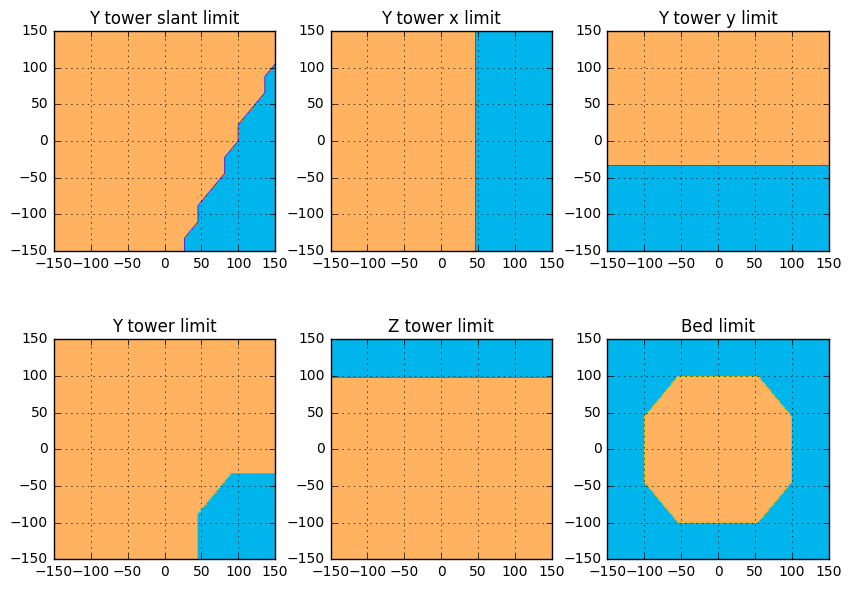

In [5]:
q = ryplot.Plotter(1,2,3,figsize=(10,7));
q.meshContour(1,xx,yy,maskYs,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower slant limit');
q.meshContour(2,xx,yy,maskYx,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower x limit');
q.meshContour(3,xx,yy,maskYy,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower y limit');
q.meshContour(4,xx,yy,maskY,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower limit');
q.meshContour(5,xx,yy,maskZ,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Z tower limit');
q.meshContour(6,xx,yy,maskB,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Bed limit');


The following graphs show the final result, in probe position and nozzle position.  The gcode file is written using the nozzle position data.

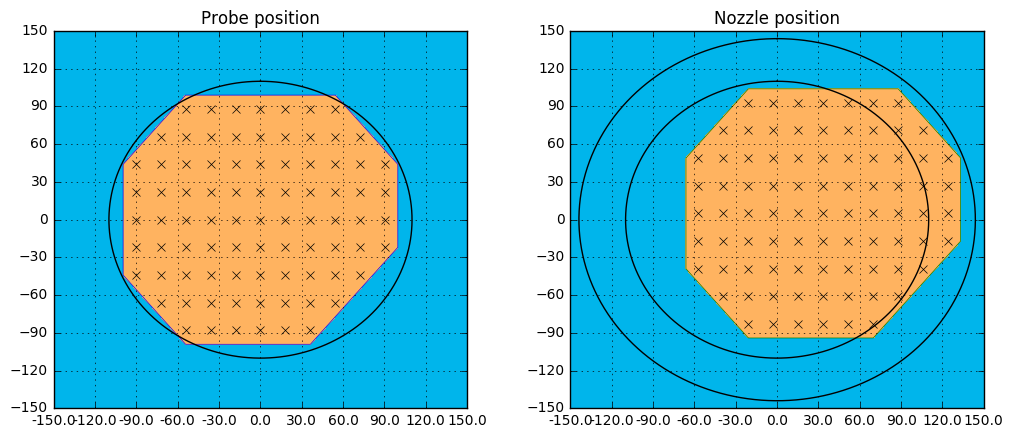

In [6]:

p = ryplot.Plotter(2,1,2,figsize=(12,5));

p.meshContour(1,xx,yy,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Probe position');
p.plot(1,xb,yb,plotCol=['k']);
p.plot(1,xx[valid],yy[valid],plotCol=['k'],markers=['x'],linestyle='');


p.meshContour(2,xx-xoffset,yy-yoffset,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Nozzle position');
p.plot(2,xb,yb,plotCol=['k']);
p.plot(2,xx[valid]-xoffset,yy[valid]-yoffset,plotCol=['k'],markers=['x'],linestyle='');
p.plot(2,xt,yt,plotCol=['k']);



Finally, the gcode file is written.

It was found that doing only one G28 homing at the start of the procedure is not sufficient, it leads to very large errors towards the end of the run (0.4 mm).  It takes a long time to G28 at every sample, but the present arrangement of G28 at every second sample appears to provide sufficient accuracy (but the procedure does takes a long time to do the frequent G28s).


In [13]:
# to write the gcode file
lst = []
for ix in range(0,xn.shape[0]):
    for iy in range(0,xn.shape[1]):
        if valid[ix,iy]:
            lst.append([xn[ix,iy],yn[ix,iy],xx[ix,iy],yy[ix,iy]])


df = pd.DataFrame(np.asarray(lst),columns=['xn','yn','xx','yy'])

header = """
;  probe the Trium bed in {} positions, {} times at each point
M119 ; print a separator in the log file
M105 ; get temperatures
G21  ; set units to mm
G90  ; absolute positioning
G28  ; home: reset coord sys by reading MAX endstops\n
""".format(df.shape[0],numg30)

footer = """
G28 ; home: reset coord sys by reading MAX endstops\n
"""

#note: we write nozzle position out here, not probe position
filename = 'g30-zprobe-{}-{}.gcode'.format(df.shape[0],numg30)
print('Writing {}'.format(filename))
with open(filename,'w') as fo:
    fo.write(header)
    for ie,idx in enumerate(df.index.values):
        strln = 'G0 X{:.3f} Y{:.3f} Z10 F3000\n'.format(df.ix[idx]['xn'],df.ix[idx]['yn'])
        fo.write(strln)
        for i in range(0,numg30):
            fo.write('G30\n')
        if not ie % numg28:
            fo.write('G28  ; home: reset coord sys by reading MAX endstops\n')
            
    fo.write(footer)

Writing g30-zprobe-84-5.gcode


After scanning the bed with the gcode file, the results are extracted from the Repetier log file (on disk) and placed in a new text file, read in and plotted.  The function below plots the results from the file.  For each position, the average is taken for all the samples at the specific point.

In [ ]:
x = [1.2, 1.3, 1.6, 2.5, 2.3, 2.8]
y = [167.0, 180.3, 177.8,160.4,179.6, 154.3]
z = [-0.3, -0.8, -0.75, -1.21, -1.65, -0.68]
data = np.c_[x,y,z]


# best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    print('coefficients {}'.format(C))
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]


21:09:10.316 : ok T:28.4 /0.0 B:75.0 /75.0 @:0 B@:0
Time 21:09:10.316 
Bed temperature is 75.0 deg C
Nozzle temperature is 28.4 deg C

Bed statistics: min=-0.176  mean=0.009  max=0.222 stddev=0.097 spread=0.398

x      -90.62  -72.50  -54.37  -36.25  -18.12   0.00    18.13   36.25   54.38   72.50   76.50
y                                                                                            
-88.0     NaN     NaN  -0.072  -0.080   0.042  -0.026   0.008   0.010     NaN     NaN     NaN
-66.0     NaN   0.022  -0.040   0.104   0.020   0.042   0.008   0.038   0.064     NaN     NaN
-44.0   0.222   0.070   0.140  -0.010   0.080   0.030   0.012   0.016   0.024   0.062     NaN
-22.0   0.146   0.030   0.120  -0.016   0.052   0.030  -0.030  -0.038  -0.036   0.004  -0.002
 0.0    0.158   0.214   0.030   0.090   0.060   0.022  -0.022  -0.082  -0.080  -0.062  -0.040
 22.0   0.138   0.160   0.160   0.060   0.010  -0.040  -0.072  -0.122  -0.118  -0.094  -0.078
 44.0   0.192   0.186   0.162   0.06

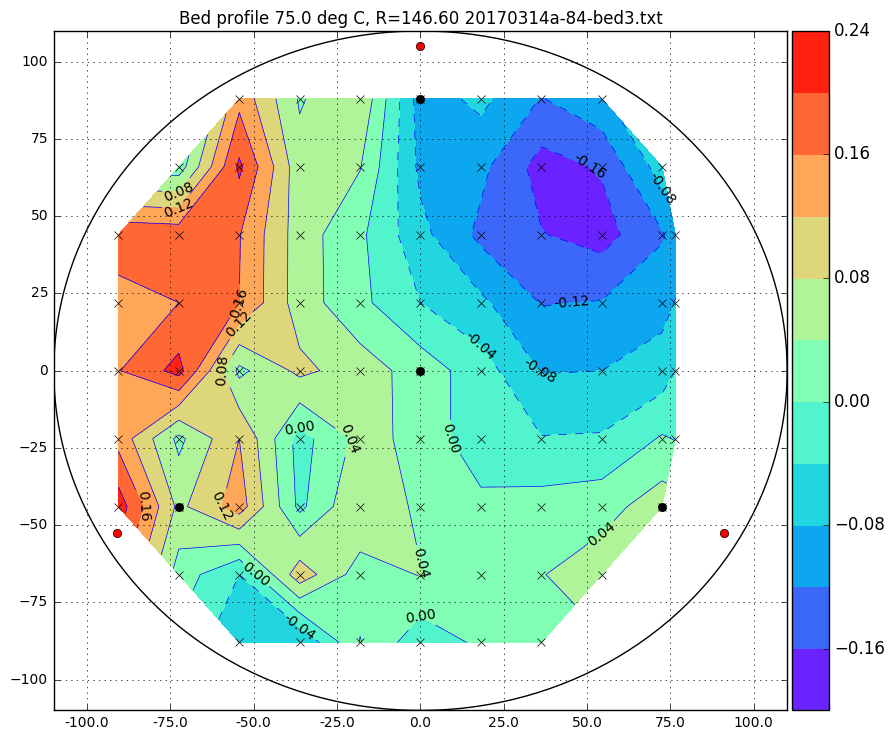

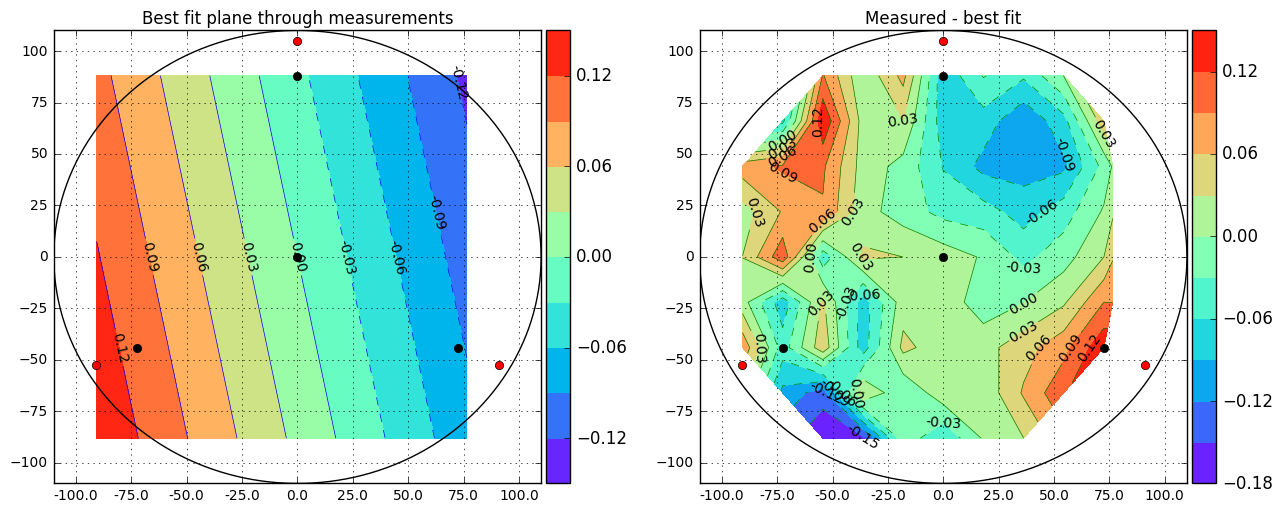

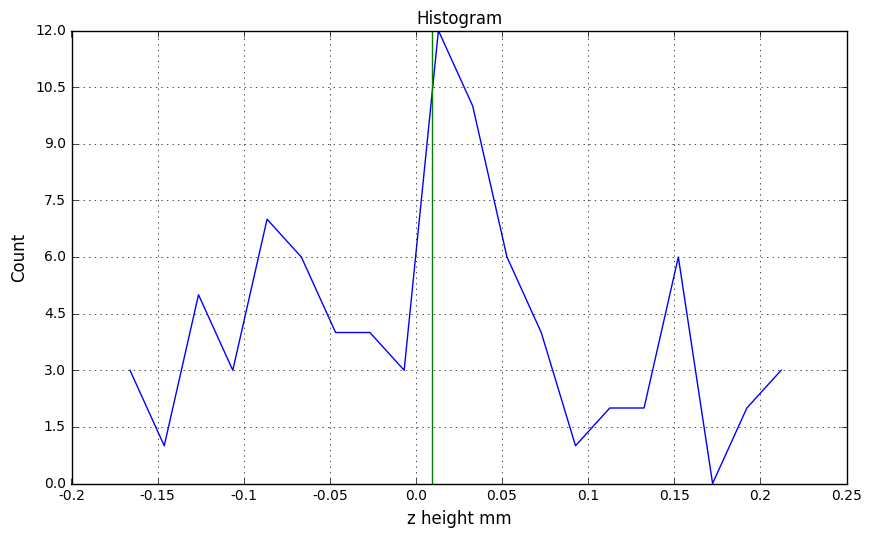

In [84]:
##
def plotBed(filename,zProbeTrigger,shimThickness):
    validlines = []
    tdone = False
    bedtemp = ''
    with open(filename,'r') as fin:
        lines = fin.readlines()
        for line in lines:
            line = line.strip()
            if len(line)>3:
                if '>' in line[0] or '<' in line[0]:
                    line = line[2:]
                lstl = line.split(' ')
                # only use lines with Bed X: in them for dataframe
                if 'Bed X:' in line:
                    # remove unwanted clutter, keep only x,y,z
                    validlines.append([float(lstl[i]) for i in [4,6,8]])
                # if temperature lines, get values
                if not tdone and 'ok' in line and 'T:' in line and 'B:' in line:
                    print(line)
                    print('Time {} '.format(lstl[0]))
                    bedtemp = lstl[5].split(':')[1]
                    print('Bed temperature is {} deg C'.format(bedtemp))
                    print('Nozzle temperature is {} deg C'.format(lstl[3].split(':')[1]))
                    tdone = True
                if 'M665' in line:
                    drad = lstl[6][1:]
    
    # here are the points used  
    calibsamples = np.asarray([[0,0],[-72.5,-44],[72.5,-44],[0,88]])
    screws = np.asarray([[0,105.],[-105*np.cos(np.pi/6.),-105*np.sin(np.pi/6.)],
                         [105*np.cos(np.pi/6.),-105*np.sin(np.pi/6.)]])
 
    # make pandas dataframe
    df = pd.DataFrame(validlines,columns=['x','y','z'])
    # the g30 command already corrected for the x,y offset
    # correct for probe offset and friction shim to get to metal
    df['x'] = df['x'] 
    df['y'] = df['y'] 
    df['z'] = df['z'] - (zProbeTrigger - shimThickness)
    
    dfr = df.groupby(by=['x','y']).aggregate(np.mean).reset_index().sort_values(by=['x','y'])
#     print(dfr)
#     print(dfr.columns)
#     print(np.max(dfr['z'])-np.min(dfr['z']))
    
    xUni = np.sort(dfr['x'].unique())
    yUni = np.sort(dfr['y'].unique())
    xUm,yUm = np.meshgrid(xUni,yUni)
    
    dfp = dfr.pivot(index='y', columns='x', values='z')
    dfpflat = dfp.values.flatten()
    print('\nBed statistics: min={:.3f}  mean={:.3f}  max={:.3f} stddev={:.3f} spread={:.3f}\n'.format(
            np.nanmin(dfpflat),np.nanmean(dfpflat), np.nanmax(dfpflat), np.nanstd(dfpflat),
            np.nanmax(dfpflat)-np.nanmin(dfpflat)))
    
#     zC = dfp.ix[] 
    print(dfp)
    
    # calculate a best-fit plane through the data points
    # https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6#file-curve_fitting-py
    A = np.c_[dfr['x'],dfr['y'],np.ones(dfr['y'].shape)]
    C,_,_,_ = scipy.linalg.lstsq(A, dfr['z'])    # coefficients
    print('Best fit plane coefficients {}'.format(C))
    # evaluate best-fit-plane on grid
#     bfplane = C[0] * xUm + C[1] * yUm + C[2]
    # ignore the z component, only look at x and y
    bfplane = C[0] * xUm + C[1] * yUm
    bestfitcorrected = dfp.values - bfplane
    print(type(bestfitcorrected))
    bestfitcorrected -= np.nanmean(bestfitcorrected.flatten())
#     bestfitcorrected -= np.nanmax(bestfitcorrected.flatten()) / 2.

    print(np.nanmean(bestfitcorrected))
    
    # measured data
    p = ryplot.Plotter(1,1,1,figsize=(10,9));
    p.meshContour(1,xUm,yUm,dfp,cbarshow=True,drawGrid=True,
                  levels=10,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                  ptitle='Bed profile {} deg C, R={} {}'.format(bedtemp,drad,filename));

    p.plot(1,xb,yb,plotCol=['k']);
    p.plot(1,dfr['x'],dfr['y'],markers=['x'],linestyle='',plotCol=['k'],linewidths=[1]);
    p.plot(1,calibsamples[:,0],calibsamples[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);
    p.plot(1,screws[:,0],screws[:,1],markers=['o'],linestyle='',plotCol=['r'],linewidths=[1]);

    # best fit plane corrected
    r = ryplot.Plotter(2,1,2,figsize=(15,6));
    r.meshContour(1,xUm,yUm,bfplane,cbarshow=True,drawGrid=True,
                  levels=10,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                  ptitle='Best fit plane through measurements');
    
    r.meshContour(2,xUm,yUm,bestfitcorrected,cbarshow=True,drawGrid=True,
                  levels=10,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                  ptitle='Measured - best fit'.format(bedtemp,drad,filename));

    for ipl in [1,2]:
        r.plot(ipl,xb,yb,plotCol=['k']);
        r.plot(ipl,calibsamples[:,0],calibsamples[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);
        r.plot(ipl,screws[:,0],screws[:,1],markers=['o'],linestyle='',plotCol=['r'],linewidths=[1]);

    
    
    
    q = ryplot.Plotter(3,1,1,figsize=(10,6))
    dfpflatnan = dfpflat[np.logical_not(np.isnan(dfpflat))]
    val, bins = np.histogram(dfpflatnan,bins=20)
    q.plot(1,(bins[:-1]+bins[1:])/2., val)
    q.plot(1,np.asarray([np.nanmean(dfpflat),np.nanmean(dfpflat)]),np.asarray([0,np.max(val)]),
          'Histogram','z height mm','Count')
    
    
plotBed('20170314a-84-bed3.txt',zProbeTrigger=0.7,shimThickness=0.1)


16:23:36.910 : ok T:28.0 /0.0 B:28.0 /0.0 @:0 B@:0
Time 16:23:36.910 
Bed temperature is 28.0 deg C
Nozzle temperature is 28.0 deg C
Best fit plane coefficients [-0.00173593 -0.00034022 -0.0599754 ]

Bed statistics: min=-0.240  mean=-0.055  max=0.176 stddev=0.109 spread=0.416

x      -90.62  -72.50  -54.37  -36.25  -18.12   0.00    18.13   36.25   54.38   72.50   76.50
y                                                                                            
-88.0     NaN     NaN   0.004  -0.026  -0.016  -0.080  -0.052  -0.068     NaN     NaN     NaN
-66.0     NaN  -0.028   0.010   0.064  -0.030  -0.038  -0.082  -0.050  -0.024     NaN     NaN
-44.0   0.176   0.040   0.142  -0.012   0.010  -0.050  -0.076  -0.070  -0.062  -0.018     NaN
-22.0   0.140   0.006   0.090  -0.058  -0.010  -0.060  -0.110  -0.140  -0.138  -0.100  -0.098
 0.0    0.140   0.170  -0.070  -0.010  -0.034  -0.070  -0.140  -0.188  -0.200  -0.158  -0.176
 22.0   0.088   0.070   0.060  -0.024  -0.088  -0.140  -0.176  -

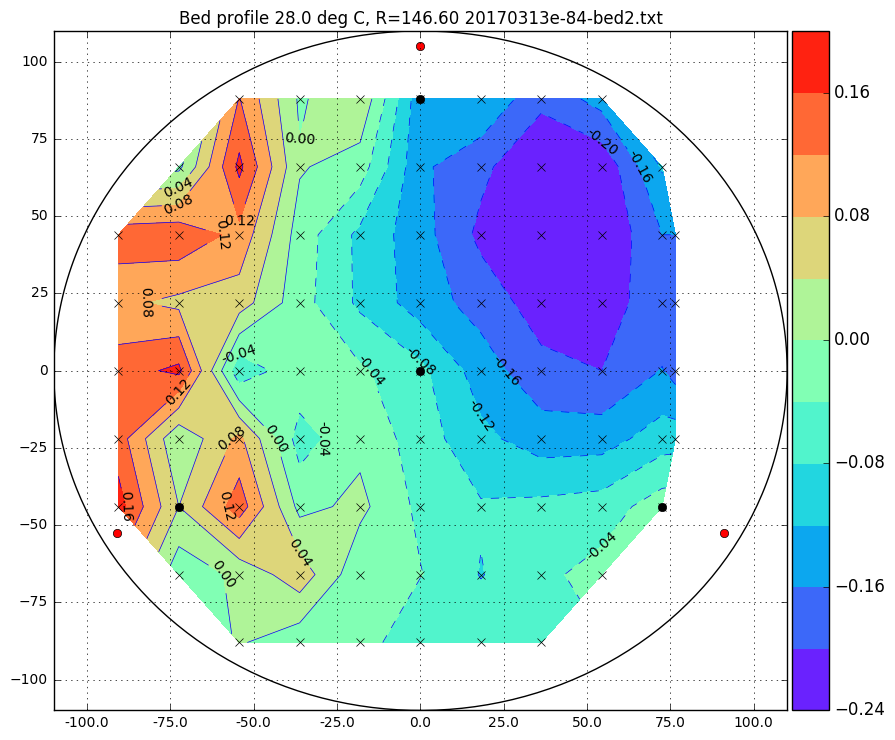

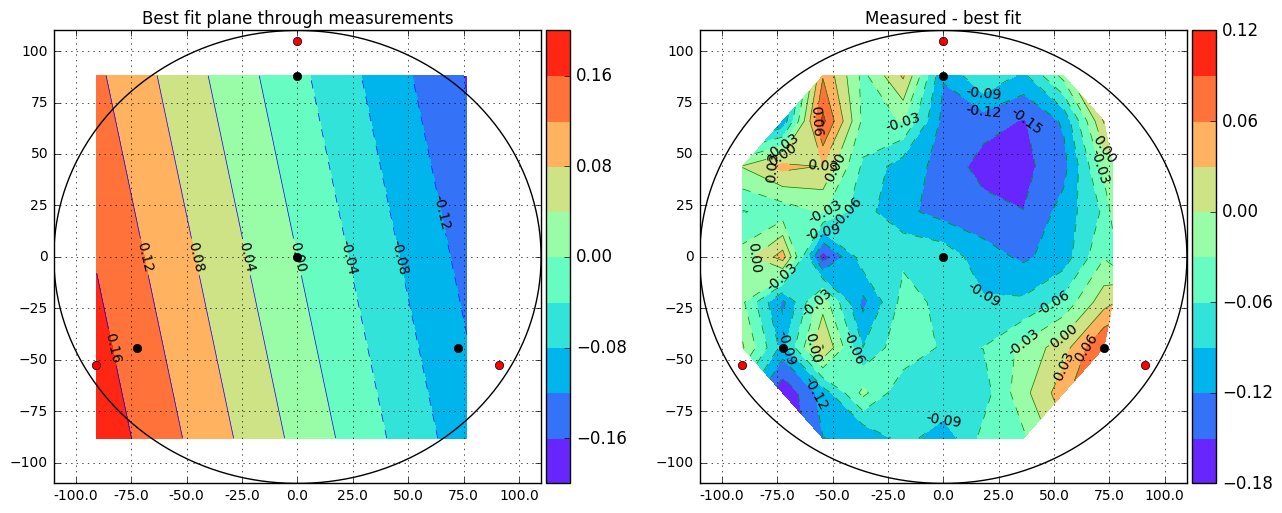

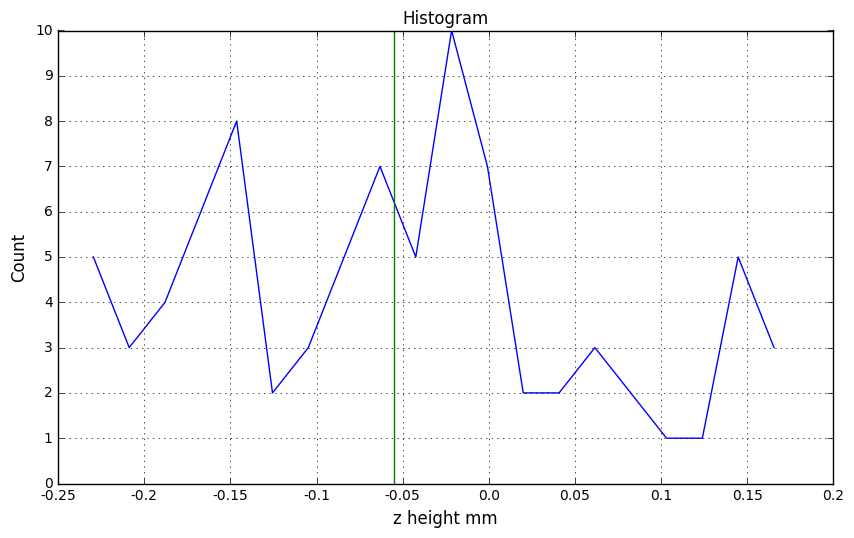

In [62]:
plotBed('20170313e-84-bed2.txt',zProbeTrigger=0.7,shimThickness=0.1)


10:50:02.081 : ok T:26.0 /0.0 B:75.3 /75.0 @:0 B@:0
Time 10:50:02.081 
Bed temperature is 75.3 deg C
Nozzle temperature is 26.0 deg C
Best fit plane coefficients [-0.00053276 -0.00045012 -0.11824698]

Bed statistics: min=-0.266  mean=-0.118  max=0.042 stddev=0.075 spread=0.308

x      -90.62  -72.50  -54.37  -36.25  -18.12   0.00    18.13   36.25   54.38   72.50   76.50
y                                                                                            
-88.0     NaN     NaN  -0.140  -0.150  -0.104  -0.128  -0.118  -0.090     NaN     NaN     NaN
-66.0     NaN  -0.212  -0.140  -0.026  -0.080  -0.082  -0.122  -0.082  -0.022     NaN     NaN
-44.0  -0.038  -0.110   0.042  -0.064  -0.036  -0.090  -0.124  -0.070  -0.042   0.022     NaN
-22.0  -0.066  -0.102   0.022  -0.100  -0.062  -0.118  -0.152  -0.150  -0.128  -0.054  -0.062
 0.0   -0.082   0.032  -0.120  -0.044  -0.092  -0.142  -0.182  -0.214  -0.196  -0.136  -0.128
 22.0  -0.088  -0.024  -0.006  -0.090  -0.146  -0.190  -0.208  

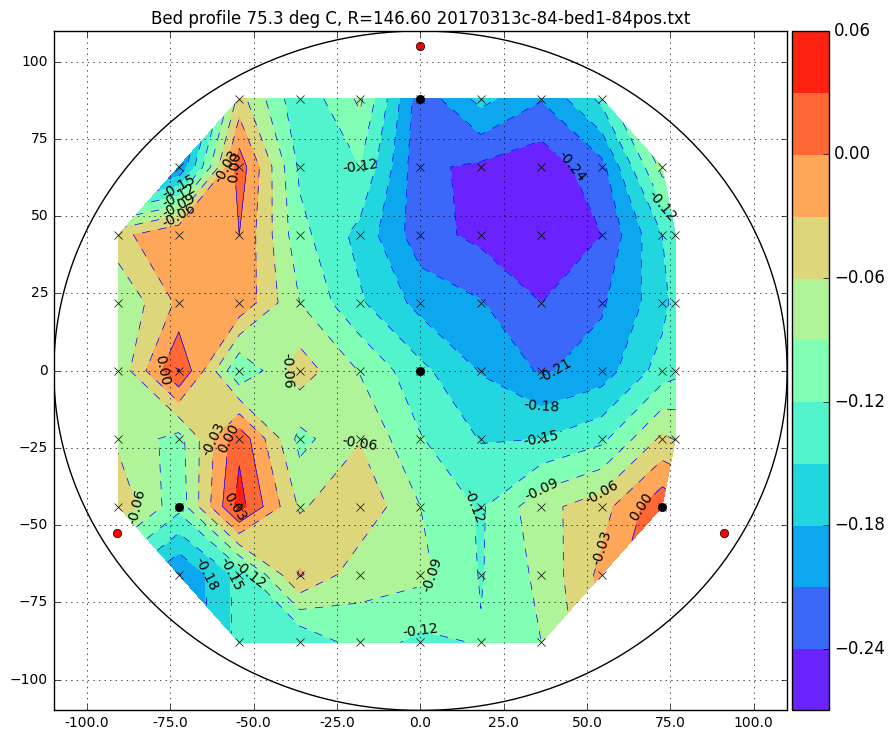

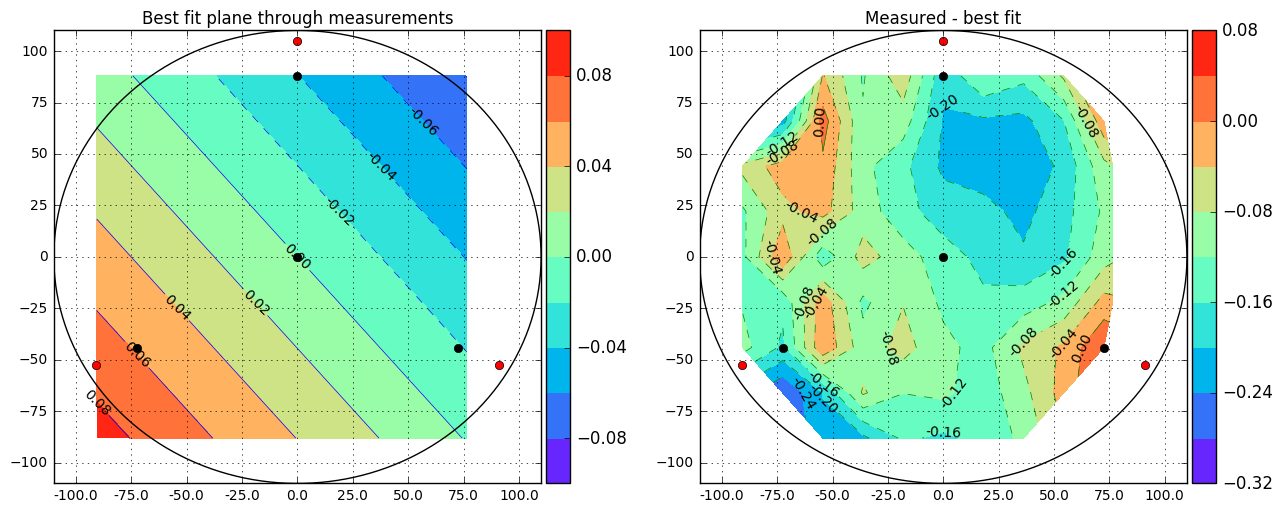

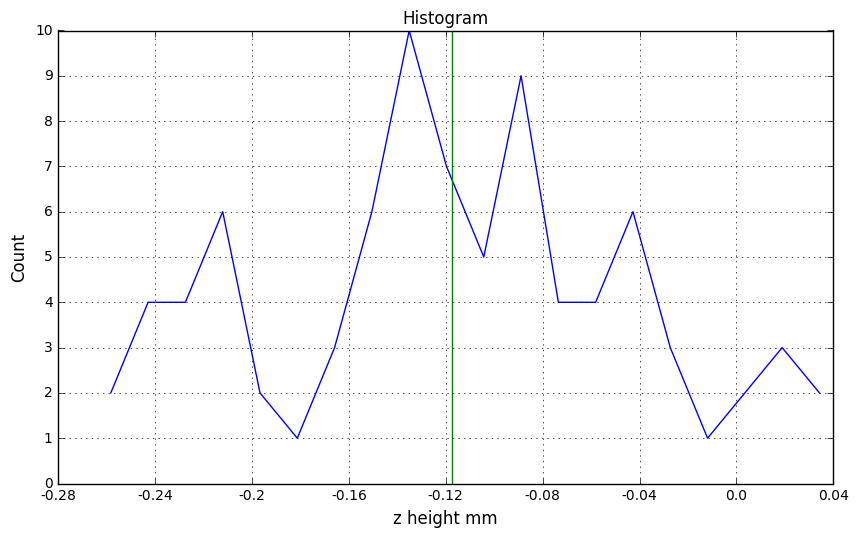

In [63]:
plotBed('20170313c-84-bed1-84pos.txt',zProbeTrigger=0.7,shimThickness=0.1)


11:46:45.507 : ok T:28.4 /0.0 B:73.3 /0.0 @:0 B@:0
Time 11:46:45.507 
Bed temperature is 73.3 deg C
Nozzle temperature is 28.4 deg C
Best fit plane coefficients [-0.00125568 -0.00017337 -0.06782714]

Bed statistics: min=-0.226  mean=-0.064  max=0.146 stddev=0.092 spread=0.372

x      -90.62  -72.50  -54.37  -36.25  -18.12   0.00    18.13   36.25   54.38   72.50   76.50
y                                                                                            
-88.0     NaN     NaN  -0.060  -0.090  -0.074  -0.110  -0.096  -0.098     NaN     NaN     NaN
-66.0     NaN  -0.132  -0.050   0.040  -0.040  -0.064  -0.092  -0.074  -0.034     NaN     NaN
-44.0   0.058  -0.012   0.130   0.010   0.006  -0.060  -0.094  -0.068  -0.058   0.002     NaN
-22.0   0.046  -0.010   0.108  -0.020  -0.008  -0.070  -0.124  -0.136  -0.120  -0.064  -0.064
 0.0    0.060   0.146  -0.030   0.010  -0.034  -0.080  -0.150  -0.190  -0.188  -0.130  -0.128
 22.0   0.018   0.070   0.080  -0.010  -0.082  -0.140  -0.172  -

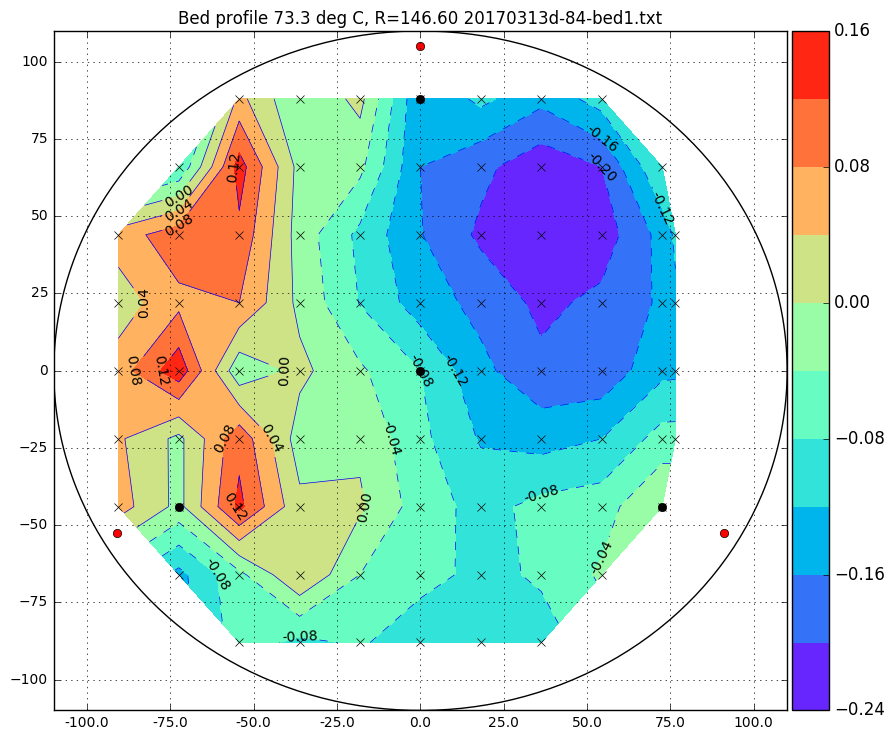

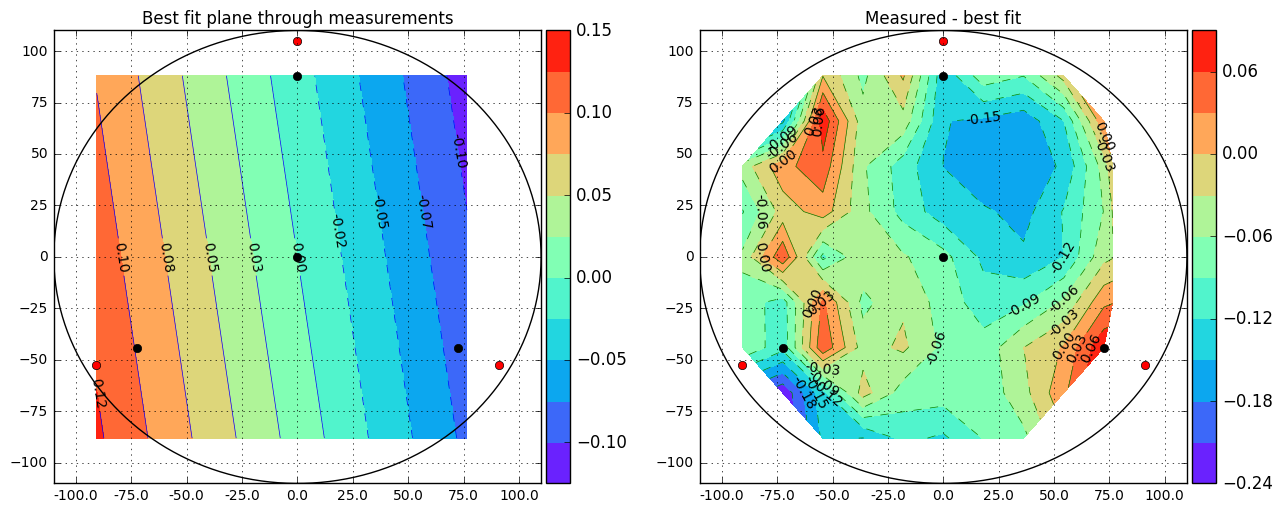

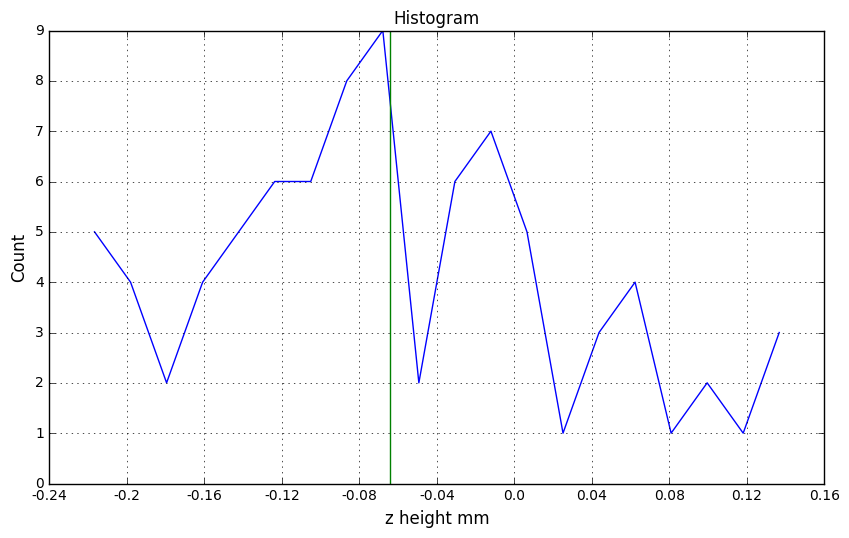

In [64]:
plotBed('20170313d-84-bed1.txt',zProbeTrigger=0.7,shimThickness=0.1)


http://www.practicalmachinist.com/vb/bridgeport-and-hardinge-mills-and-lathes/sanding-aluminum-head-rather-then-milling-220731/

http://www.mini-lathe.com/lapping/lapping.htm

http://www.overclockers.com/how-to-lap-a-heatsink/



In [ ]:
x = [1.2, 1.3, 1.6, 2.5, 2.3, 2.8]
y = [167.0, 180.3, 177.8,160.4,179.6, 154.3]
z = [-0.3, -0.8, -0.75, -1.21, -1.65, -0.68]
data = np.c_[x,y,z]

coefficients [ 1.00432668  0.32945802 -0.02352798]


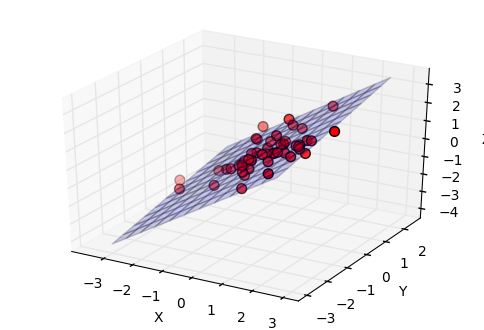

In [24]:
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# some 3-dim points
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)
# print(data)
# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(-3.0, 3.0, 0.5), np.arange(-3.0, 3.0, 0.5))
XX = X.flatten()
YY = Y.flatten()

order = 1    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    print('coefficients {}'.format(C))
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure();
ax = fig.gca(projection='3d');
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2);
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50);
plt.xlabel('X');
plt.ylabel('Y');
ax.set_zlabel('Z');
ax.axis('equal');
ax.axis('tight');
# plt.show()